In [118]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyrootutils

pyrootutils.set_root(os.path.abspath(".."), pythonpath=True)
    
from src.utils.data import load_news, load_behaviors
from src.utils.hydra import RunCollection
from src.evaluation.metrics import gs_score, ild
from src.evaluation.recommender import scoring_functions

DATA_DIR = "../data"
MIN_HISTORY_LENGTH = 3
HISTORY_MASK = False
DIVERSITY_SCORE = gs_score


In [97]:
all_runs = RunCollection.from_path("../multirun").filter_by_job("train_recommender")
all_runs = all_runs.filter_by_config_value("use_history_mask", HISTORY_MASK)

assert len(set([run.config.data.mind_variant for run in all_runs])) == 1
mind_variant = all_runs[0].config.data.mind_variant

In [104]:
# Load news
news = load_news(mind_variant, columns=["category", "subcategory", "title"], data_dir=DATA_DIR)
news = news.drop(columns="split")

# Add embeddings
embeddings_run = RunCollection.from_path("../outputs").filter_by_job("train_embeddings").one()
metrics = pd.read_csv(embeddings_run.get_file_path("metrics.csv"))
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = embeddings_run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
news = news\
    .reset_index()\
    .merge(topic_embeddings, on="subcategory")\
    .set_index("id")

# Load users
behaviors = load_behaviors(mind_variant, ["dev"], data_dir="../data")
behaviors["impression_ids"] = behaviors.impressions.apply(lambda impressions: [x.split("-")[0] for x in impressions])
behaviors["clicked"] = behaviors.impressions.apply(lambda impressions: [int(x.split("-")[1]) for x in impressions])
behaviors = behaviors\
    .drop(columns=["time", "impressions", "split"])\
    .set_index("log_id")

users = behaviors\
    .drop_duplicates(subset="user")\
    .set_index("user")\
    .drop(columns=["impression_ids", "clicked"])
users["history_length"] = users["history"].apply(len)
users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()

# Calculate user's diversity
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history.groupby("user")
users["diversity"] = user_reads.apply(lambda x: DIVERSITY_SCORE(list(x["embedding"].values)) if len(x) > 1 else None)
users["diversity percentile"] = pd.qcut(users["diversity"], np.linspace(0, 1, 6), labels=np.arange(1, 6)/5)

Using topic embeddings from epoch 3


In [127]:
def get_metrics(runs, split="dev", best_on="AUC", index_by=None, **kwargs):
    dev_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_dev.csv")).assign(run=run) for run in runs])
    dev_metrics = dev_metrics.reset_index(drop=True)
    test_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_test.csv")).assign(run=run) for run in runs])
    test_metrics = test_metrics.reset_index(drop=True)
    best_metrics = test_metrics.loc[dev_metrics.groupby("run")[best_on].idxmax()]
    for key, value in kwargs.items():
        best_metrics[key] = best_metrics["run"].apply(value)
    if index_by:
        return best_metrics.set_index(index_by, drop=True).sort_index()
    return best_metrics


def load_predictions(x, split="dev"):
    run = x.iloc[0]["run"]
    best_epoch = x.iloc[0]["epoch"]
    predictions = pd.read_feather(run.get_file_path(f"probs_{int(best_epoch)}_{split}.feather"))
    result = behaviors.merge(predictions, on="log_id").assign(run=run)
    return x[["run"]].reset_index().merge(result, on="run")


def get_individual_results(metrics, scoring_fns=scoring_functions.keys()):
    results = metrics\
        .groupby("run")\
        .apply(load_predictions)\
        .reset_index(drop=True)

    for key in scoring_fns:
        results[key] = results.apply(lambda row: scoring_functions[key](row.clicked, row.probs), axis=1)
        
    return results

## Baseline

In [80]:
baselines = all_runs.filter_by_override("+experiment", "baseline")
baseline_metrics = get_metrics(baselines, index_by="model", model=lambda run: run.overrides["+model"].upper())
baseline_metrics

,AUC,MRR,NDCG@5,NDCG@10,epoch,run
model,,,,,,
NRMS,0.661467,0.310538,0.345288,0.410346,5,Run(path=../multirun/2023-05-24/09-49-26/0)
TANR,0.665222,0.315832,0.348784,0.412684,5,Run(path=../multirun/2023-05-24/09-49-26/2)


In [ ]:
metrics = ["AUC", "MRR"]
results = get_individual_results(baseline_metrics, metrics)
averaged_per_user = results\
    .groupby(["model", "user"])\
    .agg({key: "mean" for key in metrics})\
    .reset_index()\
    .merge(users, left_on="user", right_index=True)
averaged_per_percentile = averaged_per_user\
    .groupby(["model", "diversity percentile"])\
    .agg({key: "mean" for key in metrics})

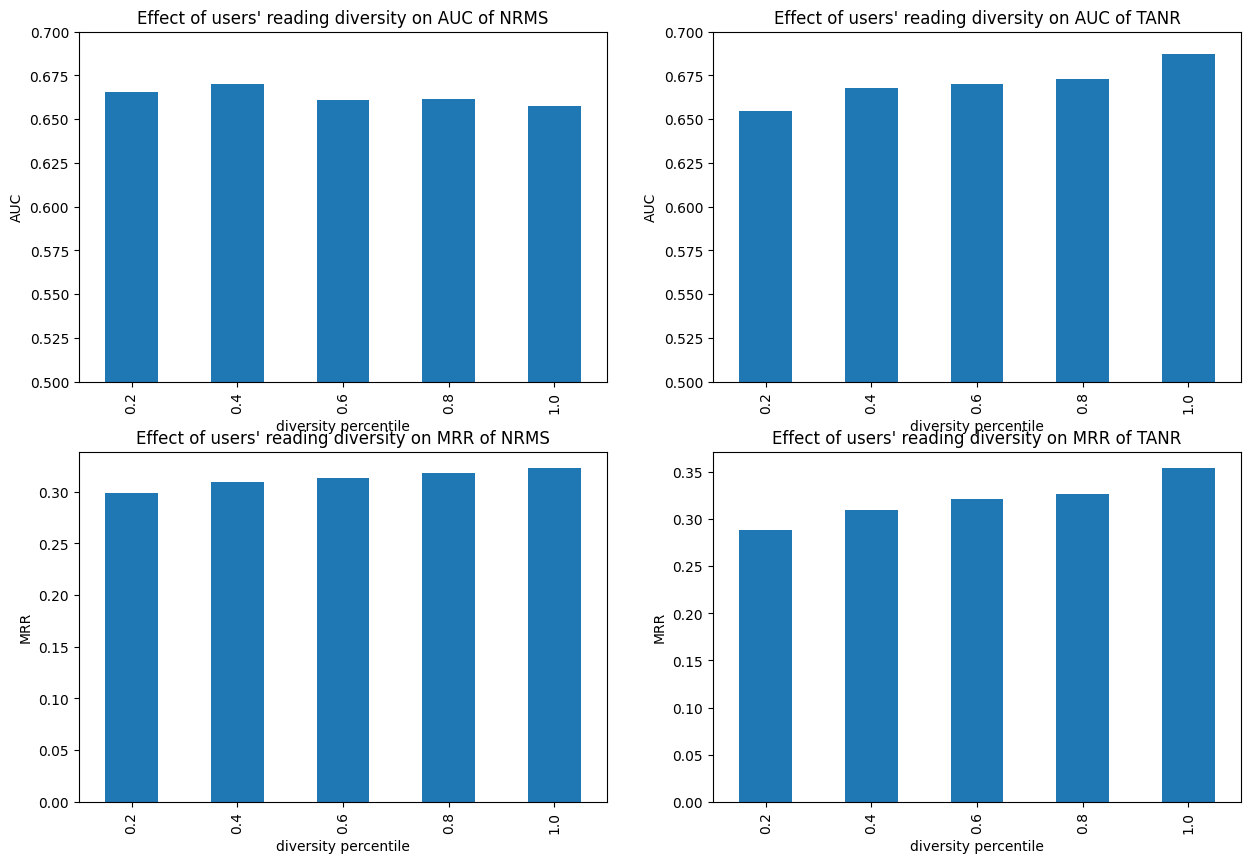

In [165]:
models = averaged_per_percentile.index.unique(0)
metrics = averaged_per_percentile.columns
fig, axs = plt.subplots(len(metrics), len(models), figsize=(15, 10))
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        averaged_per_percentile.loc[model][metric].plot.bar(ax=axs[i,j], ylabel=metric, title=f"Effect of users' reading diversity on {metric} of {model}")
        if metric == "AUC":
            axs[i,j].set_ylim((0.5, 0.7))

In [189]:
averaged_per_user\
    .groupby("model")\
    .apply(lambda x: x[["AUC", "MRR", "diversity"]].corr())\
    .drop(columns="diversity")\
    .drop(index=["AUC", "MRR"], level=1)\
    .unstack(level=1)\
    .style.set_caption("Correlation between users' reading diversity and recommendation performance")

,AUC,MRR
,diversity,diversity
model,,
NRMS,-0.011940,0.027781
TANR,0.038345,0.075045


## Number of interest vectors

### TANR

In [46]:
tanr_multi_interest = all_runs.filter_by_override("+experiment", "tanr_multi_interest")
tanr_mi_metrics = get_metrics(tanr_multi_interest, index_by="n_interest_vectors", n_interest_vectors=lambda run: run.config.model.user_encoder.n_interest_vectors)
tanr_mi_metrics

,AUC,MRR,NDCG@5,NDCG@10,epoch,run
n_interest_vectors,,,,,,
1,0.665877,0.316581,0.349810,0.413593,5,Run(path=../multirun/2023-05-24/09-54-32/0)
4,0.644460,0.303800,0.332360,0.399854,5,Run(path=../multirun/2023-05-24/09-54-32/2)
8,0.640935,0.300758,0.327983,0.394726,5,Run(path=../multirun/2023-05-24/09-54-32/4)
16,0.648626,0.304414,0.332674,0.399365,5,Run(path=../multirun/2023-05-24/09-54-32/6)
32,0.648997,0.302086,0.330733,0.397992,4,Run(path=../multirun/2023-05-24/09-54-32/8)


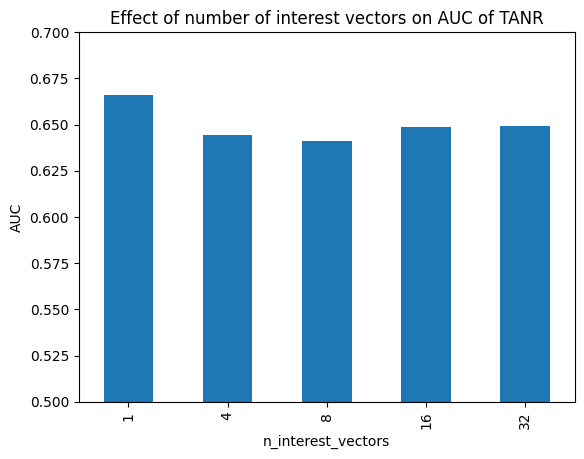

In [45]:
tanr_mi_metrics["AUC"].plot.bar(ylim=(0.5, 0.7), ylabel="AUC", title="Effect of number of interest vectors on AUC of TANR")
plt.show()

### NRMS

In [41]:
nrms_multi_interest = all_runs.filter_by_override("+experiment", "nrms_multi_interest")
nrms_mi_metrics = get_metrics(nrms_multi_interest, index_by="n_interest_vectors", n_interest_vectors=lambda run: run.config.model.user_encoder.n_interest_vectors)
nrms_mi_metrics

,AUC,MRR,NDCG@5,NDCG@10,epoch,run
n_interest_vectors,,,,,,
1,0.675691,0.327455,0.361571,0.424719,5,Run(path=../multirun/2023-05-24/09-53-29/0)
4,0.658603,0.318764,0.351762,0.413754,5,Run(path=../multirun/2023-05-24/09-53-29/2)
8,0.667854,0.321795,0.355236,0.418394,5,Run(path=../multirun/2023-05-24/09-53-29/4)
16,0.671981,0.323675,0.357446,0.420559,5,Run(path=../multirun/2023-05-24/09-53-29/6)
32,0.670664,0.323922,0.356997,0.418952,5,Run(path=../multirun/2023-05-24/09-53-29/8)


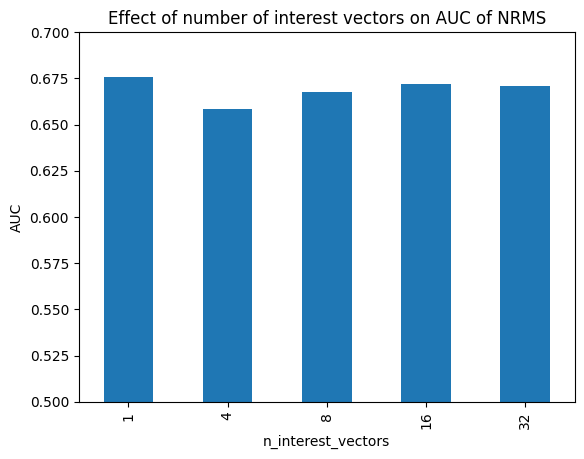

In [42]:
nrms_mi_metrics["AUC"].plot.bar(ylim=(0.5, 0.7), ylabel="AUC", title="Effect of number of interest vectors on AUC of NRMS")
plt.show()

## Effect of adding multi-interest

In [190]:
tanr_mi_multiple = tanr_mi_metrics.reset_index()
tanr_mi_multiple = tanr_mi_multiple[tanr_mi_multiple["n_interest_vectors"] > 1]
best_tanr_mi = tanr_mi_multiple.loc[tanr_mi_multiple["AUC"].idxmax()]
best_tanr_mi = best_tanr_mi.to_frame().T.assign(model="TANR", multi_interest=True)

nrms_mi_multiple = nrms_mi_metrics.reset_index()
nrms_mi_multiple = nrms_mi_multiple[nrms_mi_multiple["n_interest_vectors"] > 1]
best_nrms_mi = nrms_mi_multiple.loc[nrms_mi_multiple["AUC"].idxmax()]
best_nrms_mi = best_nrms_mi.to_frame().T.assign(model="NRMS", multi_interest=True)

multi_interest_metrics = pd.concat([
    baseline_metrics.reset_index().assign(multi_interest=False),
    best_tanr_mi,
    best_nrms_mi
]).set_index(["model", "multi_interest"]).sort_index()
multi_interest_metrics

AUC       MRR    NDCG@5   NDCG@10 epoch  \
model multi_interest                                                 
NRMS  False           0.661467  0.310538  0.345288  0.410346     5   
      True            0.671981  0.323675  0.357446  0.420559     5   
TANR  False           0.665222  0.315832  0.348784  0.412684     5   
      True            0.648997  0.302086  0.330733  0.397992     4   

                                                              run  \
model multi_interest                                                
NRMS  False           Run(path=../multirun/2023-05-24/09-49-26/0)   
      True            Run(path=../multirun/2023-05-24/09-53-29/6)   
TANR  False           Run(path=../multirun/2023-05-24/09-49-26/2)   
      True            Run(path=../multirun/2023-05-24/09-54-32/8)   

                     n_interest_vectors  
model multi_interest                     
NRMS  False                         NaN  
      True                           16  
TANR  False                         NaN  
      True                           32

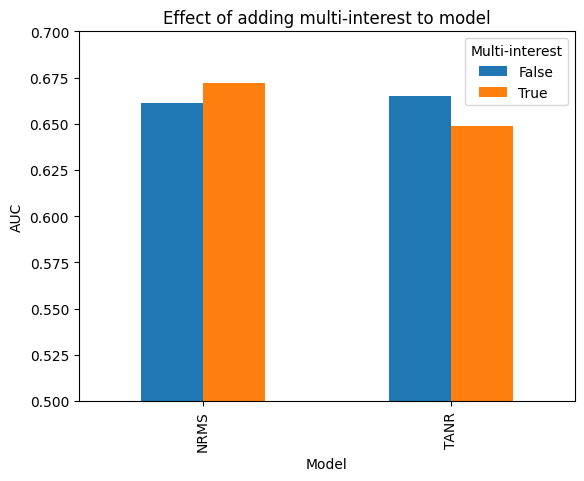

In [192]:
multi_interest_metrics.unstack(level=1)["AUC"].plot.bar(
    ylim=(0.5, 0.7), ylabel="AUC", xlabel="Model",
    title="Effect of adding multi-interest to model"
)
plt.legend(title="Multi-interest", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
metrics = ["AUC", "MRR"]
results = get_individual_results(multi_interest_metrics, metrics)
averaged_per_user = results\
    .groupby(["model", "multi_interest", "user"])\
    .agg({key: "mean" for key in metrics})\
    .reset_index()\
    .merge(users, left_on="user", right_index=True)
averaged_per_percentile = averaged_per_user\
    .groupby(["model", "multi_interest", "diversity percentile"])\
    .agg({key: "mean" for key in metrics})

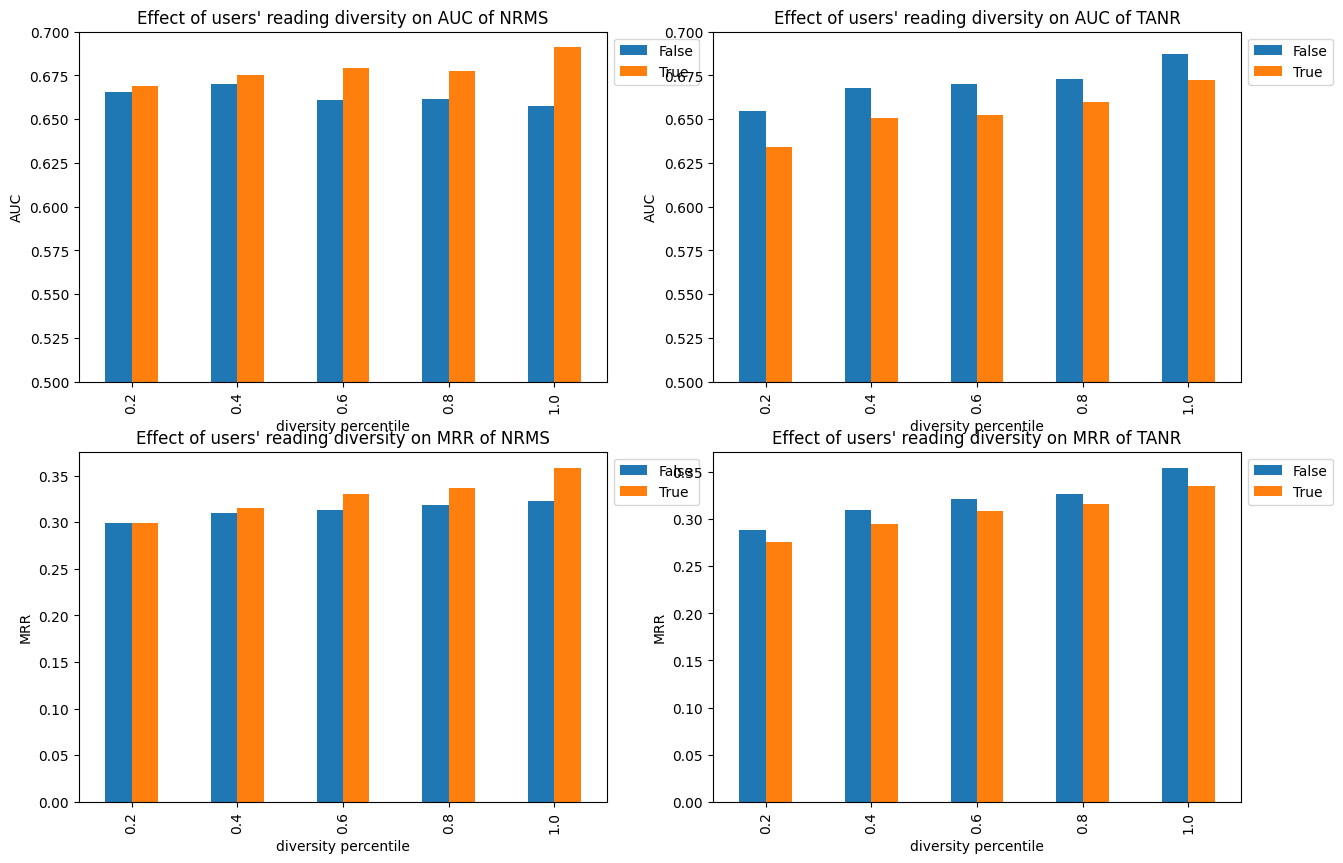

In [207]:
models = averaged_per_percentile.index.unique(0)
metrics = averaged_per_percentile.columns
fig, axs = plt.subplots(len(metrics), len(models), figsize=(15, 10))
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        averaged_per_percentile.loc[model][metric]\
            .unstack(level=0)\
            .plot.bar(ax=axs[i,j], ylabel=metric, title=f"Effect of users' reading diversity on {metric} of {model}")
        if metric == "AUC":
            axs[i,j].set_ylim((0.5, 0.7))    
        axs[i,j].legend(bbox_to_anchor=(1, 1))

In [203]:
averaged_per_user\
    .groupby(["model", "multi_interest"])\
    .apply(lambda x: x[["AUC", "MRR", "diversity"]].corr())\
    .drop(columns="diversity")\
    .drop(index=["AUC", "MRR"], level=2)\
    .unstack(level=2)\
    .style.set_caption("Correlation between users' reading diversity and recommendation performance")

## User encoder

In [52]:
user_encoder_runs = all_runs.filter_by_override("+experiment", "user_encoders")
user_encoder_metrics = get_metrics(
    user_encoder_runs,
    index_by=["news_encoder", "user_encoder"],
    news_encoder=lambda run: run.overrides["+model/news_encoder"],
    user_encoder=lambda run: run.overrides["+model/user_encoder"]
)
user_encoder_metrics

AUC       MRR    NDCG@5   NDCG@10  \
news_encoder user_encoder                                                 
nrms         additive_attention  0.675691  0.327455  0.361571  0.424719   
             mean                0.669498  0.322801  0.355757  0.419807   
             nrms                0.661467  0.310538  0.345288  0.410346   
tanr         additive_attention  0.664474  0.315847  0.348121  0.412296   
             mean                0.664741  0.316326  0.348452  0.413040   
             nrms                0.669597  0.316451  0.350235  0.414968   

                                 epoch  \
news_encoder user_encoder                
nrms         additive_attention      5   
             mean                    5   
             nrms                    5   
tanr         additive_attention      5   
             mean                    5   
             nrms                    5   

                                                                          run  
news_encoder user_encoder                                                      
nrms         additive_attention   Run(path=../multirun/2023-05-24/09-51-49/2)  
             mean                 Run(path=../multirun/2023-05-24/09-51-49/4)  
             nrms                 Run(path=../multirun/2023-05-24/09-51-49/0)  
tanr         additive_attention   Run(path=../multirun/2023-05-24/09-51-49/8)  
             mean                Run(path=../multirun/2023-05-24/09-51-49/10)  
             nrms                 Run(path=../multirun/2023-05-24/09-51-49/6)

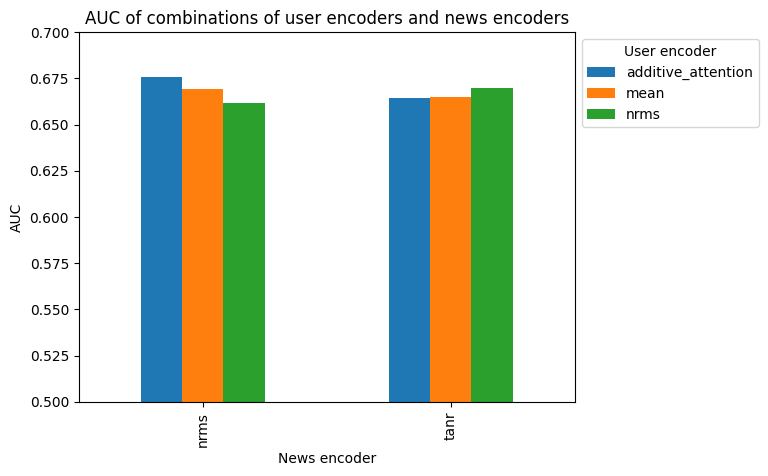

In [69]:
user_encoder_metrics.unstack(level=1)["AUC"].plot.bar(
    ylim=(0.5, 0.7), ylabel="AUC", xlabel="News encoder",
    title="AUC of combinations of user encoders and news encoders"
)
plt.legend(title="User encoder", bbox_to_anchor=(1, 1))
plt.show()